# Are MOFs Generated by Later Models Better?
We periodically retrain the DiffLinker, and hope that the ones generated by later interations of the model are better.

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import json
import gzip

In [14]:
run_dir = Path('../prod-runs/128-nodes/')

In [15]:
Path('figures').mkdir(exist_ok=True)

## Load the Data from Disk
And make it compact


In [16]:
records = []
with gzip.open(run_dir / 'mofs.json.gz', 'rt') as fp:
    for line in tqdm(fp):
        record = json.loads(line)

        # Remove structure data, label linkers by anchor
        for k in ['md_trajectory', 'nodes', 'structure', '_id']:
            del record[k]
        for ligand in record.pop('ligands'):
            record[f'ligand.{ligand["anchor_type"]}'] = ligand
            for k in ['xyz', 'dummy_element', 'anchor_type']:
                del ligand[k]

        record['time'] = record.pop('times')['created']['$date']
        records.append(pd.json_normalize(record))
records = pd.concat(records, ignore_index=True)

20449it [01:07, 302.02it/s]


Store the model versions

In [17]:
records.head()

,name,topology,catenation,time,gas_storage.CO2,structure_stability.uff,ligand.COO.name,ligand.COO.smiles,ligand.COO.prompt_atoms,ligand.COO.metadata.model_version,ligand.cyano.name,ligand.cyano.smiles,ligand.cyano.prompt_atoms,ligand.cyano.metadata.model_version
0,mof-4343cbf3,None,None,2024-04-12T05:53:32.731Z,"[10000.0, 0.0749183669]",0.234871,ligand-52a167ec,O=C([O-])c1ccc(C#C/C=C/[S+]=C/c2ccc(C(=O)O)cc2...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-751aee98,N#Cc1ccc(C#CC#CC#Cc2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0
1,mof-ce4de002,None,None,2024-04-12T05:53:20.518Z,"[10000.0, 0.1465915317]",0.183405,ligand-f71a1c7c,[O-][C+](O)[C-]1[CH+][CH+][C+]([C]C[C][C][CH+]...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-4aa8ea30,N#Cc1ccc(C#CC=C=C=Cc2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0
2,mof-cdf23986,None,None,2024-04-12T05:53:35.070Z,"[10000.0, 0.0735757833]",0.286085,ligand-8812b1f2,[O-][C+](O)[C-]1[CH+][CH+][C+]([C][C][CH+][C][...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-1f097886,N#Cc1ccc(C#CC#CC#Cc2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0
3,mof-e81c3537,None,None,2024-04-12T05:53:40.145Z,"[10000.0, 0.0919397753]",0.239671,ligand-f71a1c7c,[O-][C+](O)[C-]1[CH+][CH+][C+]([C]C[C][C][CH+]...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-c53f9b86,N#Cc1ccc(C#CC#CC#Cc2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0
4,mof-9a34f44c,None,None,2024-04-12T05:53:19.335Z,"[10000.0, 0.0929561246]",0.402651,ligand-f71a1c7c,[O-][C+](O)[C-]1[CH+][CH+][C+]([C]C[C][C][CH+]...,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,ligand-d8ef139f,N#Cc1ccc(C#CC#CC#Cc2ccc(C#N)cc2)cc1,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, ...",0


In [18]:
records['model_version'] = records[['ligand.cyano.metadata.model_version', 'ligand.COO.metadata.model_version']].max(axis=1)

In [19]:
records['time'] = records['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
records['walltime'] = (records['time'] - records['time'].min()).apply(lambda x: x.total_seconds())

In [20]:
records.sort_values('walltime', inplace=True)

## Plot Stability over Time
Do they get better or worse over time?

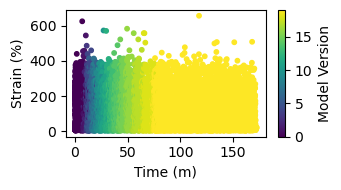

In [21]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

sc = ax.scatter(records['walltime'] / 60, records['structure_stability.uff'] * 100, s=10,
           c=records['model_version'])

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (m)')
ax.set_ylabel('Strain (%)')

fig.tight_layout()
fig.savefig('figures/stability-over-time.png', dpi=320)

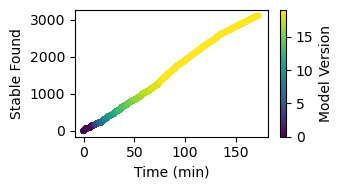

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

records['cumulative_found'] = (records['structure_stability.uff'] < 0.1).cumsum()
sc = ax.scatter(
    records['walltime'] / 60,
    records['cumulative_found'],
    s=10, c=records['model_version']
)
#ax.step(records['walltime'] / 60, count, zorder=-1, c='k', lw=1)

fig.colorbar(sc, label='Model Version')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Stable Found')

fig.tight_layout()
fig.savefig('figures/stability-over-time-step.png', dpi=320)

Save results

In [23]:
summary_dir = Path('summaries')
summary_dir.mkdir(exist_ok=True)

In [24]:
records.to_csv(summary_dir / f'{run_dir.name}.csv.gz', index=False)